# Time Series Forecasting
This notebook includes the predictive analysis part of the project uthat uses two Time Series Forcasting algorithms:
    1. Prophet
    2. ARIMA

## **Time Series Forcasting to predict future number of accident using FB's Prophet** 

> The study of time series accounts for the fact that data points taken over time can have an internal structure that should be accounted for (such as trend or seasonal variation, autocorrelation)

> Prophet is a method focused on a model for forecasting time series data where non-linear patterns match with annual , monthly, and regular seasonality, plus holiday results. It works better with time series that have clear seasonal effects and historical data from many seasons. Prophet is immune to missing data and pattern changes, and usually manages outliers well.

### Installation

1. !pip install fbprophet
2. !pip install --upgrade plotly
3. !pip install matplotlib

### Importing Libraries

In [63]:
import fbprophet
import pandas as pd
import numpy as np
from fbprophet import Prophet
import plotly
import warnings
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
# ignore warning messages
warnings.filterwarnings("ignore")

# Printing prophet version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.6


> There are three accident files from year 2017-2019
> Since all of the files have same columns, appending was straight forward.

In [64]:
# Read all years accident data
df_0 = pd.read_csv('data/Road_Safety_Data_Accidents_2017.csv')
df_2 = pd.read_csv('data/Road_Safety_Data_Accidents_2018.csv')
df_3 = pd.read_csv('data/Road_Safety_Data_Accidents_2019.csv')

#Converting the date column to type Datetime
df_0['Date']=pd.to_datetime(df_0.Date,format='%d/%m/%Y')
df_2['Date']=pd.to_datetime(df_2.Date,format='%d/%m/%Y')
df_3['Date']=pd.to_datetime(df_3.Date,format='%d/%m/%Y')

#Appending all the three file contents
df_0=df_0.append(df_2, ignore_index=True)
df_0=df_0.append(df_3, ignore_index=True)

df_=df_0

>**Splitting the data - All records before 2019-01-30 will be train and after it till 2019-12-31 will be in test set**

In [65]:
# Split by data for training and testing
df_["Date"] = pd.to_datetime(df_['Date'])
split_date = "2019-01-31"

df = df_.loc[df_.Date <= split_date].copy()
test = df_.loc[df_.Date > split_date].copy()

# Convert to datetime format
df['Date'] = pd.to_datetime(df.Date) 
test['Date'] = pd.to_datetime(test.Date) 


> **The input to the Prophet is always a two-column data frame: ds and y.**
<br> The ds column should have the format anticipated by Pandas, preferably YYYY-MM-DD for a date or YYYY-MM-DD HH: MM: SS for a timestamp. 
<br> The y column must be numeric, reflecting the measurement that we want to estimate.

<br> In this step I am grouping the accidents by date so we have a dataframe ready in acceptable form


In [66]:
# Creating train and test dataframe acceptable by Prophet (ds(Date) and y(Count))

df_1 = (pd.to_datetime(df['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count'))

test_1 = (pd.to_datetime(test['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count'))

In [67]:
# Train set
df_1.tail()

,Date,count
756,2018-12-26,174
757,2018-03-04,167
758,2018-03-03,163
759,2017-12-25,137
760,2018-12-25,130


### Seasonality Vs Trend
<img src="trend.png">
<br> The image shows how Seasonal and trend looks like.
<br>After analysing the data, I figured out that the data possess seasonal properties.
<br>This has been shown for Accident data in the plot below

In [68]:
# Renaming the columns because Prophet needs them in these names
df_1.columns = ['ds', 'y']
test_1.columns = ['ds', 'y']
df_1

,ds,y
0,2017-12-01,559
1,2017-09-22,509
2,2018-01-19,504
3,2017-10-27,504
4,2017-05-26,503
...,...,...
756,2018-12-26,174
757,2018-03-04,167
758,2018-03-03,163
759,2017-12-25,137


Text(0.5, 0.98, 'Seasonal')

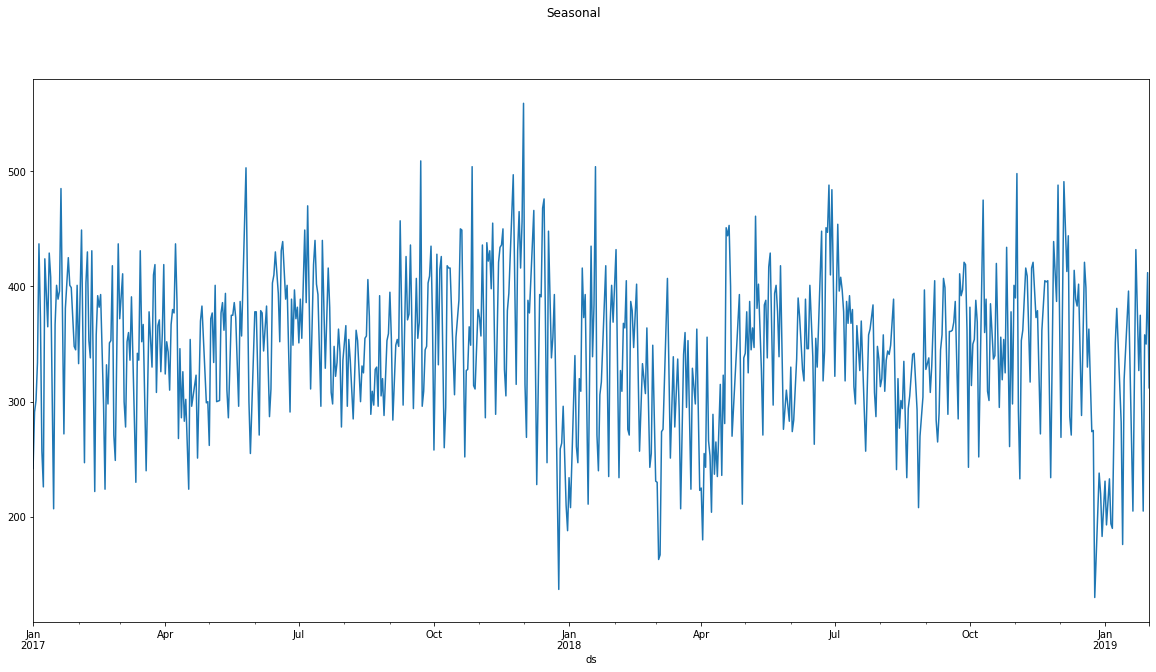

In [69]:
#Copying into another datframe just for displaying the visualization
df_1copy=df_1.copy()

#Sort values by date as time series needs data ordered
df_1copy.sort_values(by='ds',inplace=True)
df_1copy.set_index('ds',inplace=True)

#bfill propagates the first observed non-null value backward until previous non-null value is met.
df_1copy = df_1copy.fillna(df_1copy.bfill())
df_1copy['y'].plot(figsize=(20, 10))
plt.suptitle('Seasonal')

#### In order to continue, we must instantiate a new object of the Prophet. The Prophet makes a variety of arguments to be specified.
>Apart from the ds and y columns, I wanted to add regressors which will weight on the forecast. 
<br> Regressor values must be in the same data frame as the data from the time series data.

 *model.add_regressor('feature_name') will add the feature in regressor set*
 
 >> I had added regressors from vehicle.csv to check if the forecasting improves, but it negatively affected the resul. Hence I removed the vehicle specific regressors (Vehicle Type, Journey Purpose of Driver, etc)
 
 <br>The following features were correlated according to the initial exploration I performed on Accident data
1. Local_Authority_(District) and Police_Force
2. Junction_Detail and 2nd_Road_Class
3. Speed_Limit and Urban_Rural
<br> Hence, I am keeping only one feature from each pair

In [70]:
# Defining the model
model = Prophet(daily_seasonality=True)

# Sorting train data by date
df_1.sort_values(by='ds',inplace=True)

# Adding additional features to train set other than ds and y for regression
df_1['Day_of_Week']=df['Day_of_Week']
df_1['Light_Conditions']=df['Light_Conditions']
df_1['Weather_Conditions']=df['Weather_Conditions']
df_1['Speed_limit']=df['Speed_limit']
df_1['Pedestrian_Crossing-Physical_Facilities']=df['Pedestrian_Crossing-Physical_Facilities']
df_1['Police_Force']=df['Police_Force']
df_1['2nd_Road_Class']=df['2nd_Road_Class']
df_1['Number_of_Vehicles']=df['Number_of_Vehicles']
df_1['Special_Conditions_at_Site']=df['Special_Conditions_at_Site']

## I had tried adding these regressors and validated the performance , but it didnt help so removed them
## I had tried adding features from Vehicles.csv and that didin't help the performance either.
## The RMSE was 11.51 when vehicle data was added as regressor

#df_1['Road_Type'] = df['Road_Type']
#df_1['Road_Surface_Conditions']=df['Road_Surface_Conditions']
#df_1['Longitude']=df['Longitude']
#df_1['Latitude']=df['Latitude']
#df_1['1st_Road_Class']=df['1st_Road_Class']
#df_1['1st_Road_Number']=df['1st_Road_Number']
#df_1['Urban_or_Rural_Area']=df['Urban_or_Rural_Area']


In [71]:
# Adding regressors to determine the impact of events

model.add_regressor('Day_of_Week',mode='multiplicative')
model.add_regressor('Light_Conditions',mode='multiplicative')
model.add_regressor('Weather_Conditions',mode='multiplicative')
model.add_regressor('Speed_limit',mode='multiplicative')
model.add_regressor('Pedestrian_Crossing-Physical_Facilities',mode='multiplicative')
model.add_regressor('Special_Conditions_at_Site',mode='multiplicative')
model.add_regressor('Number_of_Vehicles',mode='multiplicative')
model.add_regressor('Police_Force',mode='multiplicative')
model.add_regressor('2nd_Road_Class',mode='multiplicative')

#model.add_regressor('Urban_or_Rural_Area',mode='additive')
#model.add_regressor('Road_Surface_Conditions',mode='additive')
#model.add_regressor('Longitude',mode='additive')
#model.add_regressor('Latitude',mode='additive')
#model.add_regressor('Road_Type',mode='additive')
#model.add_regressor('1st_Road_Class',mode='additive')
#model.add_regressor('1st_Road_Number',mode='additive')

> Facebook Prophet is not searching for any causal links between the past and the future. Instead, it simply attempts to use a linear or logistic curve and Fourier coefficients for the seasonal components to find the best curve to match the results. There is also an aspect of regression, but it is for external regressors, not the time series itself. The regressors help in adding additional features while model building. In our application, we needed a model to understand the effect of features such as ‘Road Type’ was important.
By design, Prophet can provide the trend variable with uncertainty intervals by simulating potential trend shifts in your time series. You should run a few hundred iterations (which takes a few minutes) if you want to model uncertainty regarding future seasonality or holiday impact, and your predictions may provide projections of seasonal uncertainty. Prophet provides an option to set strong multiple “human-scale” seasonalities: day of week and time of year.


In [72]:
# fit the model
model.fit(df_1)

### Seasonality Types - Additive or Multiplicative
<img src="seasonaltypes.gif">

According to these characteristes, Multiplicative seasonality with no trend worked best for our dataset

#### After fitting the model by adding regressors, I need to add the same features to test set

In [73]:
# Sorting test data by date
test_1.sort_values(by='ds',inplace=True)

# Adding additional features to test set other than ds and y for regression
test_1['Day_of_Week']=df_['Day_of_Week']
test_1['Light_Conditions']=df_['Light_Conditions']
test_1['Weather_Conditions']=df_['Weather_Conditions']
test_1['Speed_limit']=df_['Speed_limit']
test_1['Pedestrian_Crossing-Physical_Facilities']=df_['Pedestrian_Crossing-Physical_Facilities']
test_1['Police_Force']=df_['Police_Force']
test_1['2nd_Road_Class']=df_['2nd_Road_Class']
test_1['Special_Conditions_at_Site']=df_['Special_Conditions_at_Site']
test_1['Number_of_Vehicles']=df_['Number_of_Vehicles']

## I had tried adding these regressors and validated the performance , but it didnt help so removed them
## I had tried adding features from Vehicles.csv and that didin't help the performance either.

#test_1['Urban_or_Rural_Area']=df_['Urban_or_Rural_Area']
#test_1['Road_Surface_Conditions']=df_['Road_Surface_Conditions']
#test_1['Longitude']=df_['Longitude']
#test_1['Latitude']=df_['Latitude']
#test_1['1st_Road_Class']=df_['1st_Road_Class']
#test_1['1st_Road_Number']=df_['1st_Road_Number']
#test_1['Road_Type'] =df_['Road_Type']

#### Using the model for forecasting
> *yhat is the predicted value* 
<br> *yhat_lower, yhat_upper are the uncertainty interval (predicted range can be between these two values)*

          ds        yhat  yhat_lower  yhat_upper
0 2019-02-01  363.801753  312.128971  409.655565
1 2019-02-02  304.143902  259.275628  355.459594
2 2019-02-03  247.204025  195.038513  294.298810
3 2019-02-04  323.116349  271.167573  372.149819
4 2019-02-05  339.562007  290.997927  390.055953


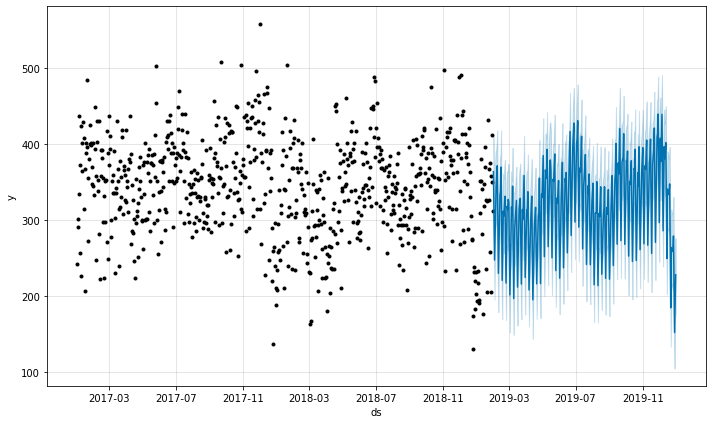

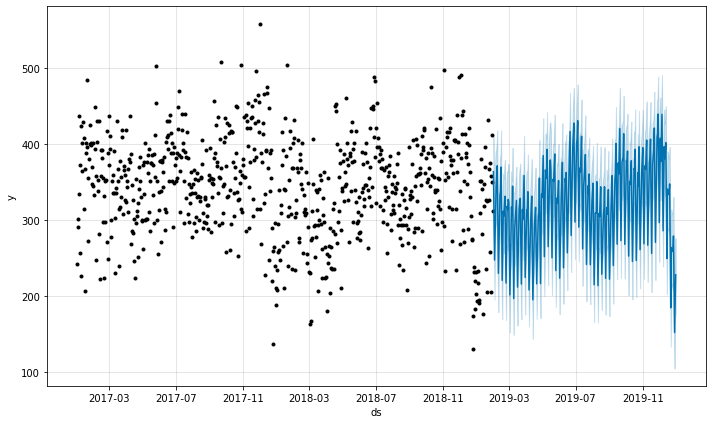

In [74]:
# Prediction on test data
forecast = model.predict(test_1)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plotting forecast
model.plot(forecast)

#### Historic Data_______________________________________________________________Forecasted Data

#### Comparing the original value and predicted value

In [75]:
metric_df = forecast.set_index('ds')[['yhat']].join(test_1.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
329,2019-12-27,279.065851,204
330,2019-12-28,195.687384,174
331,2019-12-29,151.675461,163
332,2019-12-30,223.407283,245
333,2019-12-31,227.872808,232


#### Calculating Rsquare 

In [76]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# metric_df.y is original value and metric_df.yhat is predicted value
r2_score(metric_df.y, metric_df.yhat)

0.6557293346697717

#### Calculating RMSE

In [77]:
from math import sqrt
prophet_rmse=sqrt(mean_absolute_error(metric_df.y, metric_df.yhat))
prophet_rmse

4.955967988042122

### Cross Validation
> Using the cross_validation function, cross validation procedure is automatically for a range of historical cutoffs.
<br>The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. [4] 
1. Forecast horizon (horizon)
2. Size of the initial training period is optional (initial)
3. Spacing between cutoff dates (period).

In [78]:
df_cv = cross_validation(model, initial='366 days', period='60 days', horizon = '100 days')
df_cv

INFO:fbprophet:Making 5 forecasts with cutoffs between 2018-02-25 00:00:00 and 2018-10-23 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-02-26,302.446173,255.747408,347.375102,255,2018-02-25
1,2018-02-27,344.541729,299.107266,391.476880,349,2018-02-25
2,2018-02-28,324.731407,276.761134,372.170585,291,2018-02-25
3,2018-03-01,330.267312,280.661402,374.929926,231,2018-02-25
4,2018-03-02,357.469067,310.242028,403.765910,230,2018-02-25
...,...,...,...,...,...,...
495,2019-01-27,279.303581,233.618499,324.698279,205,2018-10-23
496,2019-01-28,327.567707,280.247644,373.298668,358,2018-10-23
497,2019-01-29,371.424909,324.465238,418.817952,350,2018-10-23
498,2019-01-30,368.970551,322.456545,415.966994,412,2018-10-23


### Performance Metrics
>"The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates" [4]

In [79]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,2550.710906,50.504563,39.881056,0.136661,0.094690,0.70
1,11 days,2510.847084,50.108353,39.176884,0.135000,0.092441,0.70
2,12 days,2612.537266,51.112985,40.355483,0.138273,0.094690,0.72
3,13 days,2485.195794,49.851738,39.169171,0.130115,0.091578,0.72
4,14 days,2264.237944,47.584009,36.745631,0.119825,0.090307,0.72
...,...,...,...,...,...,...,...
86,96 days,1630.264962,40.376540,33.183640,0.107395,0.089624,0.66
87,97 days,1575.857480,39.697071,32.785751,0.106791,0.083415,0.68
88,98 days,1538.831927,39.227948,32.607903,0.104656,0.083415,0.70
89,99 days,1578.981933,39.736406,33.876965,0.106405,0.093353,0.72


### References
##### [1] https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
##### [2] https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
##### [3] https://futurice.com/blog/business-forecasting-with-facebook-prophet
##### [4] https://facebook.github.io/prophet/docs/diagnostics.html

# Implementing ARIMA using Statsmodels and Python


### Installation

1. !pip install itertools
2. !pip install statsmodels

In [80]:
import warnings
import matplotlib.pyplot as plt
import itertools
from math import sqrt
import numpy as np
import pandas as pd
import statsmodels.api as sm
warnings.filterwarnings("ignore") # ignore warning messages
plt.style.use('fast')

#### Splitting The train data - All records until 2019-01-31

In [81]:
# Read all years accident data
df_0 = pd.read_csv('data/Road_Safety_Data_Accidents_2017.csv')
df_2 = pd.read_csv('data/Road_Safety_Data_Accidents_2018.csv')
df_2['Date']=pd.to_datetime(df_2.Date,format='%d/%m/%Y')
df_3 = pd.read_csv('data/Road_Safety_Data_Accidents_2019.csv')
df_3['Date']=pd.to_datetime(df_3.Date,format='%d/%m/%Y')

df_0=df_0.append(df_2, ignore_index=True)
df_0=df_0.append(df_3, ignore_index=True)

#### Splitting my date and keeping the columns in ARIMA accepted format - Date as index and the target column 

In [82]:
df_0["Date"] = pd.to_datetime(df_0['Date'])
split_date = "2019-01-30"

df = df_0.loc[df_0.Date <= split_date].copy()

df_=(pd.to_datetime(df['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count'))

In [83]:
#Preparing the test data
test = df_0.loc[df_0.Date > split_date].copy()
test_=(pd.to_datetime(test['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count'))

#### SARIMAX, which stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors

> ARIMA, which stands for the AutoRegressive Integrated Moving Average model, is a mixture of two model forms, namely the AutoRegressive model and the Moving Average model, and the differentiation method. ARIMA and related models presume some kind of causal link between past values and past failures and future time series values. Sometimes, more configuration is required for algorithms such as ARIMA to achieve realistic results, which is out of the scope of many people who are not experts. We wanted to explore. Seasonality and exogenous influences (seasonality and normal ARIMA do not blend well) are the contrast between ARIMA and SARIMAX. We tested the model with both simple ARIMAX and SARIMAX, SARIMAX performed better for our data. The reason for this is that our dataset possesses Seasonal characteristics.

<br>It is one of the methods used in Python to model and forecast the future points of a time sequence.
> Ffill or forward-fill propagates the last observed non-null value forward until next non-null value is encountered. 
<br> Bfill or backward-fill propagates the first observed non-null value backward until previous non-null value is met.

In [84]:
df_.sort_values(by='Date',inplace=True)
df_.set_index('Date',inplace=True)
data = df_.fillna(df_.bfill())

test_.sort_values(by='Date',inplace=True)
test_.set_index('Date',inplace=True)
test_data = test_.fillna(test_.bfill())
print(test_data)

            count
Date             
2019-01-31    312
2019-02-01    318
2019-02-02    294
2019-02-03    257
2019-02-04    336
...           ...
2019-12-27    204
2019-12-28    174
2019-12-29    163
2019-12-30    245
2019-12-31    232

[335 rows x 1 columns]


#### When we plot the results, certain distinguishable trends emerge.

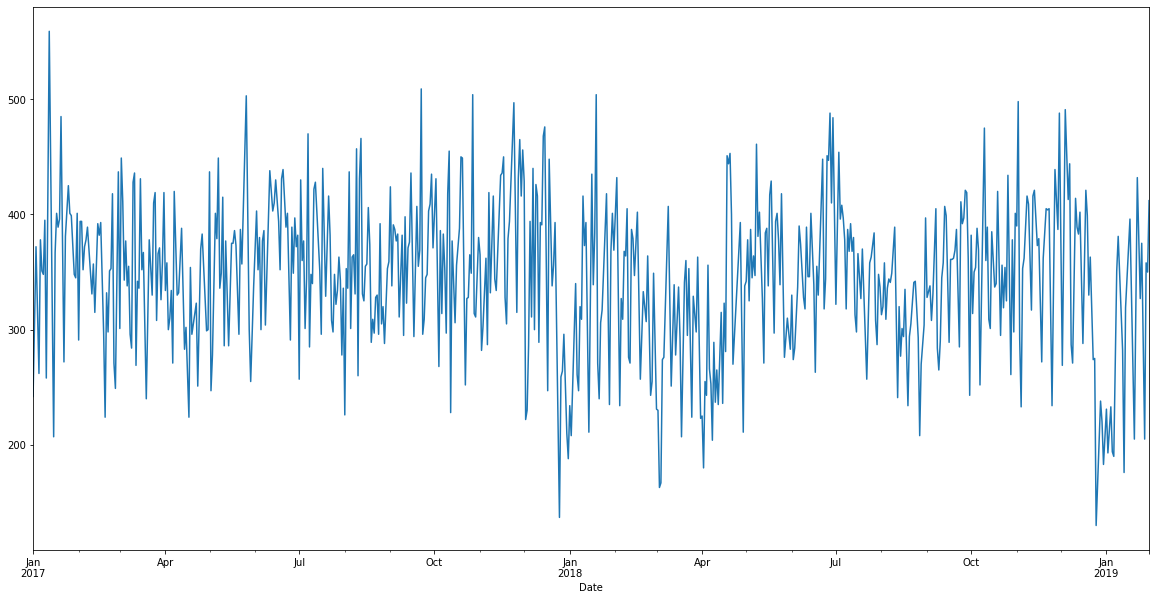

In [85]:
data['count'].plot(figsize=(20, 10))
plt.show()

#### p : The auto-regressive component of the model. It helps us to integrate into our model the influence of previous values.
#### d : The incorporated portion of the model is d. This involves terminology in the model that include the amount of variation to be added to the time series (i.e. the number of prior time points to be subtracted from the present value).
#### q : Moving average component of model. This helps one to set our model 's error as a linear combination of the error values found in the past at prior points in time.

In [86]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
p_d_q = list(itertools.product(p, d, q))

# Generate combinations of p, q and q
pdq_seasonal = [(param[0], param[1], param[2], 12) for param in list(itertools.product(p, d, q))]

#### I can use the above-defined parameter triplets to simplify the training process and test ARIMA models in various combinations.
> This method is known as grid search.
<br> AIC (Akaike Information Criterion) value that is easily returned using statsmodels with ARIMA models fitted. 
<br> The AIC tests how well a model has fit by keeping the model 's total complexity into account.

In [87]:
for param in p_d_q:
    for seasonal_param in pdq_seasonal:
        try:
            inter_model = sm.tsa.statespace.SARIMAX(data['count'],
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_invertibility=False,
                                            enforce_stationarity=False
                                            )

            inter_output = inter_model.fit()

            print('ARIMA{}param{}12 - AIC:{}'.format(param, seasonal_param, inter_output.aic))
        except:
            continue

ARIMA(0, 0, 0)param(0, 0, 0, 12)12 - AIC:11049.896788461134
ARIMA(0, 0, 0)param(0, 0, 1, 12)12 - AIC:10138.351958211037
ARIMA(0, 0, 0)param(0, 1, 0, 12)12 - AIC:8856.073387193715
ARIMA(0, 0, 0)param(0, 1, 1, 12)12 - AIC:8256.95067044286
ARIMA(0, 0, 0)param(1, 0, 0, 12)12 - AIC:8858.591854322996
ARIMA(0, 0, 0)param(1, 0, 1, 12)12 - AIC:8428.338039738639
ARIMA(0, 0, 0)param(1, 1, 0, 12)12 - AIC:8543.997835129248
ARIMA(0, 0, 0)param(1, 1, 1, 12)12 - AIC:8258.581325955993
ARIMA(0, 0, 1)param(0, 0, 0, 12)12 - AIC:10192.319483653699
ARIMA(0, 0, 1)param(0, 0, 1, 12)12 - AIC:9618.475841851487
ARIMA(0, 0, 1)param(0, 1, 0, 12)12 - AIC:8763.991299092733
ARIMA(0, 0, 1)param(0, 1, 1, 12)12 - AIC:8113.610528613973
ARIMA(0, 0, 1)param(1, 0, 0, 12)12 - AIC:8770.313378536997
ARIMA(0, 0, 1)param(1, 0, 1, 12)12 - AIC:8249.278817109462
ARIMA(0, 0, 1)param(1, 1, 0, 12)12 - AIC:8420.650794423196
ARIMA(0, 0, 1)param(1, 1, 1, 12)12 - AIC:8108.666346485704
ARIMA(0, 1, 0)param(0, 0, 0, 12)12 - AIC:8558.66415573

#### From the returned AIC, I chose the combination with least AIC but with order (0,0,0) because the data is seasonal. So I kept the trend parameters 0 -> 8267
#### order=(0, 0, 0)
#### seasonal_order=(0, 1, 1, 12)

The 4 parameters of seasonal_order represent:
1. P: Seasonal autoregressive order.
2. D: Seasonal difference order.
3. Q: Seasonal moving average order.
3. m: The number of time steps for a single seasonal period.

In [88]:
model = sm.tsa.SARIMAX(data['count'],
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False,
                                enforce_stationarity=False
                                )
output = model.fit()

#### Predicting for unseen records -> 2019-02-01 to 2019-12-31

In [89]:
predictions = output.get_prediction(start='2019-02-01',end='2019-12-31', dynamic=False)
forecasted = predictions.predicted_mean
original = test_data['2019-02-01':]

#### Calculating RMSE

In [90]:
mse = ((forecasted - original['count']) ** 2).mean()
arima_rmse=round(sqrt(mse), 2)
print('The RMSE is {}'.format(arima_rmse))

The RMSE is 59.33


### Refrences
#### https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
#### https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
#### https://365datascience.com/sarimax/
#### https://towardsdatascience.com/using-pandas-transform-and-apply-to-deal-with-missing-data-on-a-group-level-cb6ccf060531#:~:text=method%3D'ffill'%3A%20Ffill,non%2Dnull%20value%20is%20met

### Comparing ARIMA and Prophet

#### As displayed in the plot, <u>Prophet</u>  had much lower RMSE
#### The Root Mean Square Error is a commonly used as an ndicator of the differences between the values forecasted and the values observed by the model.

In [91]:
compare=pd.DataFrame()
compare['Algorithm']=['ARIMA','Prophet']
compare['RMSE']=[arima_rmse,prophet_rmse]
compare.set_index('Algorithm',inplace=True) 

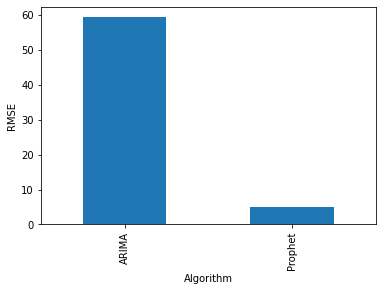

In [92]:
compare.plot.bar(legend=None)
plt.xlabel("Algorithm") 
plt.ylabel("RMSE") 
plt.show() 